# modelforge.curate : Basic Usage

This notebook will demonstrate basic usage of the `curate` module in modelforge, developed to make it easier to create modelforge compatible HDF5 datasets with a uniform structure.  This module puts an emphasis of validation at the time of construction. 

In the curate module, we have 3 levels of hierarchy: 

- At the top most level, we have a dataset (i.e., an instance of `SourceDataset`)
- A dataset contains records (instances of the `Record` class)
- Each record contains properties (each property is defined as a Pydantic model that is a child of the `PropertyBaseModel` class)

To start, let us import the packages we need


In [1]:
from modelforge.curate import Record, SourceDataset
from modelforge.utils.units import GlobalUnitSystem
from modelforge.curate import AtomicNumbers, Positions, Energies, Forces, MetaData

from openff.units import unit

import numpy as np

## Set up a new dataset
Next, we will create an instance of the `SourceDataset` class to store the dataset, providing a `name` for the dataset as a string. 

In [2]:
new_dataset = SourceDataset(name="test_dataset")

2025-05-28 16:08:35.724 | WARNING  | modelforge.curate.sourcedataset:__init__:66 - Database file test_dataset.sqlite already exists in ./. Removing it.


## Create a record

To create a record, we  instantiate the `Record` class providing a unique `name` as a string; this `name` will be used within the dataset to access/update records and thus needs to be unique.

In [3]:
record_mol1 = Record(name='mol1')

## Define properties
The curate packages provides pydantic models for many common properties reported in datasets. 

Each record must include a few basic elements to be considered complete, namely:
- **atomic numbers**
- **positions**
- **energies**
  
Records may of course contain other properties/metadata, but this is the minimal set of information required by modelforge during training. 

### Property classifications
Properties are classified into four categories. These categories are used to validate the inputs (including the shape of the underlying arrays).  These classifications are also used within modelforge to know how to parse information from the dataset (as the shape of the associated array itself may not be sufficient).  

The four categories as as follows: 
- **atomic_numbers** -- array must have a shape (n_atoms,1). Regardless of the number of configurations in a property, the atomic numbers must be consistent, and thus do not need to be defined separately for each configuration.
- **per_system** -- array must have a at least 2 dimensions, where the first dimension corresponds to the configuration, i.e., (n_configs, X). Energy is an example of a per_system property with shape (n_configs, 1)
- **per_atom** -- array must have at least 3 dimensions, where the first two dimensions correspond to the configuration, and the second the atom, i.e., (n_configs, n_atoms, X). Partial charge is an example of a per_atom property with shape (n_config, n_atoms, 1)
- **meta_data** -- there are no shape requirements for meta_data, however, input is limited to the following types: string, float, int, list, numpy array

Users do not need to set the classification of a property for the pre-defined models within the module; the appropriate value is defined by default. 

### Defining atomic numbers
Let us consider how to initialize atomic numbers, in this case for a methane CH4:

In [4]:
atomic_numbers = AtomicNumbers(value=np.array([[6], [1], [1], [1], [1]]))

The array that stores the atomic numbers must have the shape (n_atoms, 1).  An error will be raised if `len(value.shape) != 2` or `value.shape[1] != 1`. 

Properties can accept either a numpy array or a python list as input; the python list it will be converted to a numpy array automatically.  For example, the following syntax will produce an equivalent instance:

In [5]:
atomic_numbers = AtomicNumbers(value=[[6], [1], [1], [1], [1]])

### Defining positions

To define positions, we will use the `Positions` pydantic model.  Since positions must have units associated with them, they must be set at the time of initialization.  The property models do not include a default unit, unless the property does not require units (e.g., such as `AtomicNumbers`). 

Units can be passed as an openff.units `Unit` or a string that can be understood by openff.units. An error will be raised if units are not defined, or if the units passed are not compatible (i.e., not a length measurement for `Positions`).

Positions are a "per_atom" property storing the x,y, and z positions and thus must be 3d array with shape (n_configs, n_atoms, 3).
If `value.shape[2] !=3` or `len(value.shape) != 3`, this will raise an error.  



In [6]:
positions = Positions(
    value=np.array([[[0.0, 0.0, 0.0], [0.109, 0.0, 0.0], [-0.054, 0.094, 0.0], [-0.054, -0.094, 0.0], [0.0, 0.0, 0.109]]]), 
    units="nanometer"
)

We can easily examine the positions, where we can see the `value`, `units`, `classification` and `property_type` (used to ensure unit compatibility); this also will determine the `n_configs` and `n_atoms` based on the shape of the underlying array.

In [7]:
print(positions)

name='positions' value=array([[[ 0.   ,  0.   ,  0.   ],
        [ 0.109,  0.   ,  0.   ],
        [-0.054,  0.094,  0.   ],
        [-0.054, -0.094,  0.   ],
        [ 0.   ,  0.   ,  0.109]]]) units=<Unit('nanometer')> classification='per_atom' property_type='length' n_configs=1 n_atoms=5


### Defining energies 
To define energies, we will use the `Energies` pydantic model; as with positions, units must also be set.  

Note, energy is a "per_system" property and thus the shape of the input array must be (n_configs, 1); an error will be raised if `value.shape[1] !=1` or `len(value.shape) != 2`.

In [8]:
energies = Energies(
    value=np.array([[0.1]]), 
    units=unit.hartree
)

### Definiting meta data

We can also provide meta data in the form of int, float, str, list, or numpy arrays.  These properties do not necessarily undergo any significant validation as this information is not used directly by modelforge. 

Below is an example of using the MetaData class to define the smiles of the molecule, passed as a string. 

Note, a SMILES property class could be defined that includes validation, e.g., passing the string to RDKit to ensure it is valid, however this has not been implemented at the current time. 

In [9]:
smiles = MetaData(name='smiles', value='C')

### Other properties

Pydantic models have been defined for the following properties at the time of creating this tutorial:
- `atomic_numbers`
- `Energies`
- `Positions`
- `Forces`
- `PartialCharges`
- `TotalCharge`
- `SpinMultiplicities`
- `DipoleMomentPerSystem`
- `DipoleMomentPerAtom`
- `DipoleMomentScalarPerSystem`
- `QuadrupoleMomentPerSystem`
- `QuadrupoleMomentPerAtom`
- `OctupoleMomentPerAtom`
- `Polarizability`
- `BondOrders`
- `MetaData`

Note, each of these models inherits from a more general `PropertyBaseClass` pydantic model; this model can be used to define any additional properties, but requires the user to provide the classification (e.g., per_atom, per_system) and the property_type (for the purposes of unit conversion, e.g., length, energy, force, charge, etc.). 

Classes for additional properties can be added to the module as well; this set was generated based on what was encountered within the current datasets supported by `modelforge`.

**More information on defining properties is provided in the "defining_properties.ipynb" notebook.**

## Add properties to a record

Having defined properties we can now add them to the record. Properties can be added individually to the record or provided as a list:

In [10]:
record_mol1.add_property(atomic_numbers)
record_mol1.add_properties([positions,energies, smiles])

By default when instantiating a new `Record` instance, `append_property = False`.
If `append_property == False`, an error will be raised if you try to add a property with the same name more than once to the same record. This ensures we do not accidentally overwrite data in a record.

They following will produce a ValueError because "energies" have already been set for the record.  Note, in all cases, atomic_numbers can only be set once, regardless of the state of append_property, as it is a unique case. 

In [11]:
record_mol1.add_property(energies)

ValueError: Property with name energies already exists in the record mol1.Set append_property=True to append to the existing property.

### Validating a record

The use of pydantic allows for considerable validation at the time of initialization of the properties, e.g., ensuring units have been set, compatibility of units, and minimal examination of the shape of the input array.  However, since each property is defined separately, we are unable to cross validate n_atoms and n_configs until those properties are grouped into a record. 

An individual record can be validated to ensure consistency of n_configs and n_atoms.  Since this minimal only has 3 properties, this checks that n_atoms in `atomic_numbers` matches `positions` and n_configs matches in `energies` and `positions`. 


In [12]:
record_mol1.validate()

True

### Viewing a record
Printing a record provides a summary of the contents.  

In [13]:
print(record_mol1)

name: mol1
* n_atoms: 5
* n_configs: 1
* atomic_numbers:
 -  name='atomic_numbers' value=array([[6],
       [1],
       [1],
       [1],
       [1]]) units=<Unit('dimensionless')> classification='atomic_numbers' property_type='atomic_numbers' n_configs=None n_atoms=5
* per-atom properties: (['positions']):
 -  name='positions' value=array([[[ 0.   ,  0.   ,  0.   ],
        [ 0.109,  0.   ,  0.   ],
        [-0.054,  0.094,  0.   ],
        [-0.054, -0.094,  0.   ],
        [ 0.   ,  0.   ,  0.109]]]) units=<Unit('nanometer')> classification='per_atom' property_type='length' n_configs=1 n_atoms=5
* per-system properties: (['energies']):
 -  name='energies' value=array([[0.1]]) units=<Unit('hartree')> classification='per_system' property_type='energy' n_configs=1 n_atoms=None
* meta_data: (['smiles'])
 -  name='smiles' value='C' units=<Unit('dimensionless')> classification='meta_data' property_type='meta_data' n_configs=None n_atoms=None



The record can also be exported to a dict. 

In [14]:
record_mol1.to_dict()

{'name': 'mol1',
 'n_atoms': 5,
 'n_configs': 1,
 'atomic_numbers': AtomicNumbers(name='atomic_numbers', value=array([[6],
        [1],
        [1],
        [1],
        [1]]), units=<Unit('dimensionless')>, classification='atomic_numbers', property_type='atomic_numbers', n_configs=None, n_atoms=5),
 'per_atom': {'positions': Positions(name='positions', value=array([[[ 0.   ,  0.   ,  0.   ],
          [ 0.109,  0.   ,  0.   ],
          [-0.054,  0.094,  0.   ],
          [-0.054, -0.094,  0.   ],
          [ 0.   ,  0.   ,  0.109]]]), units=<Unit('nanometer')>, classification='per_atom', property_type='length', n_configs=1, n_atoms=5)},
 'per_system': {'energies': Energies(name='energies', value=array([[0.1]]), units=<Unit('hartree')>, classification='per_system', property_type='energy', n_configs=1, n_atoms=None)},
 'meta_data': {'smiles': MetaData(name='smiles', value='C', units=<Unit('dimensionless')>, classification='meta_data', property_type='meta_data', n_configs=None, n_atoms=

Records can be converted to RDKit molecules. 

In [15]:
rd_mol = record_mol1.to_rdkit()

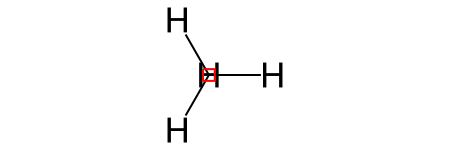

In [16]:
rd_mol

## Add a record to a dataset

To add a record to the dataset, we use the `add_record` function of `SourceDataset`.

Note, the `name` field of the record is used as a unique identifier.  You cannot add two records with the same `name`. 

In [17]:
new_dataset.add_record(record_mol1)

The entire dataset can validated.  This essentially just calls the validate function on the individual records, as well as ensure that the minimal set of properties exist (atomic_numbers, energies, and positions). 

In [18]:
new_dataset.validate_records()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 458.34it/s]
2025-05-28 16:09:18.939 | INFO     | modelforge.curate.sourcedataset:validate_records:782 - All records validated successfully.


True

## Saving to an HDF5 file

To save ths to an hdf5 file, we call the `to_hdf5` function of the `SourceDataset` class, passing the output path and filename. This will automatically perform the validation discussed above before we write to the file. 

Additionally, when writing the file, it will convert records to a consistent unit system (by default, `kilojoules_per_mole` and `nanometers` are the base unit system for energy and distance), as defined by the `GlobalUnitSystem` class (discussed below).

Note this returns the md5 checksum of the file. 

In [19]:
checksum = new_dataset.to_hdf5(file_path="./", file_name="test_dataset.hdf5")

2025-05-28 16:09:19.717 | INFO     | modelforge.curate.sourcedataset:to_hdf5:915 - Validating records
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 620.09it/s]
2025-05-28 16:09:19.720 | INFO     | modelforge.curate.sourcedataset:validate_records:782 - All records validated successfully.
2025-05-28 16:09:19.720 | INFO     | modelforge.curate.sourcedataset:to_hdf5:918 - Writing records to .//test_dataset.hdf5
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|

## Reading from an HDF5 file

Any hdf5 files generate with the `modelforge.curate` module can also be loaded into an instance of `SourceDataset` using the `create_dataset_from_hdf5` function. 

In [20]:
from modelforge.curate import create_dataset_from_hdf5

new_dataset_from_hdf5 = create_dataset_from_hdf5(hdf5_filename="test_dataset.hdf5", dataset_name="test_dataset2")

2025-05-28 16:09:20.441 | WARNING  | modelforge.curate.sourcedataset:__init__:66 - Database file test_dataset2.sqlite already exists in ./. Removing it.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 273.62it/s]


If we examine the original dataset and the one loaded from the hdf5 file we will see they contain the same information. 

Note that, because we convert units when we write to file (as discussed above), the "energies" property is in units of `kilojoules_per_mole` for the dataset read in from the file. 

In [21]:
print("original dataset\n")
print(" -records:", new_dataset.keys())
print(" -total records: ",new_dataset.total_records())
print(" -total configs: ", new_dataset.total_configs())
print(" -record mol1: \n\n", new_dataset.get_record("mol1"))

print("***************\n")
print("dataset generated from hdf5\n")
print(" -records:", new_dataset_from_hdf5.keys())
print(" -total records: ",new_dataset_from_hdf5.total_records())
print(" -total configs: ", new_dataset_from_hdf5.total_configs())
print(" -record mol1: \n\n", new_dataset_from_hdf5.get_record("mol1"))


original dataset

 -records: ['mol1']
 -total records:  1
 -total configs:  1
 -record mol1: 

 name: mol1
* n_atoms: 5
* n_configs: 1
* atomic_numbers:
 -  name='atomic_numbers' value=array([[6],
       [1],
       [1],
       [1],
       [1]]) units=<Unit('dimensionless')> classification='atomic_numbers' property_type='atomic_numbers' n_configs=None n_atoms=5
* per-atom properties: (['positions']):
 -  name='positions' value=array([[[ 0.   ,  0.   ,  0.   ],
        [ 0.109,  0.   ,  0.   ],
        [-0.054,  0.094,  0.   ],
        [-0.054, -0.094,  0.   ],
        [ 0.   ,  0.   ,  0.109]]]) units=<Unit('nanometer')> classification='per_atom' property_type='length' n_configs=1 n_atoms=5
* per-system properties: (['energies']):
 -  name='energies' value=array([[0.1]]) units=<Unit('hartree')> classification='per_system' property_type='energy' n_configs=1 n_atoms=None
* meta_data: (['smiles'])
 -  name='smiles' value='C' units=<Unit('dimensionless')> classification='meta_data' propert

## Global Unit system and unit validation

When defining individual properties, units are also validated.  When defining a property, users can specify any unit that is:
- (1) supported by openff.units
- (2) compatible with the parameter type (i.e., Positions expect a unit of length).

Bullet 2 is assessed by comparing to the default values in the `GlobalUnitSystem` class (note, we are not making any unit conversions at the point of initializing a record, just checking for compatibility). 

The following will fail validation because we expect positions to be defined in distance units. 

In [22]:
pos = Positions(value=[[[1.0, 1.0, 1.0], [2.0, 2.0, 2.0], [3.0, 3.0, 3.0]]], units=unit.angstrom*unit.angstrom)


ValidationError: 1 validation error for Positions
  Value error, Unit angstrom ** 2 of positions are not compatible with the property type length.
 [type=value_error, input_value={'value': [[[1.0, 1.0, 1....<Unit('angstrom ** 2')>}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.8/v/value_error

Units are stored as class attributes within the `GlobalUnitSystem` class. 

In [32]:
from modelforge.utils.units import GlobalUnitSystem
print(GlobalUnitSystem())

area : nanometer ** 2
atomic_numbers : dimensionless
charge : elementary_charge
dimensionless : dimensionless
dipole_moment : elementary_charge * nanometer
energy : kilojoule_per_mole
force : kilojoule_per_mole / nanometer
frequency : gigahertz
heat_capacity : kilojoule_per_mole / kelvin
length : nanometer
name : default
octupole_moment : elementary_charge * nanometer ** 3
polarizability : nanometer ** 3
pressure : standard_atmosphere
quadrupole_moment : elementary_charge * nanometer ** 2
wavenumber : 1 / centimeter


Since these are class attributes, not instance variables, any changes or additions to the `GlobalUnitSystem `will apply to all usages within the script. For example, the following will change the units for length to angstroms. 

In [24]:
GlobalUnitSystem.set_global_units('length', unit.angstrom)

print(GlobalUnitSystem.get_units('length'))

angstrom


The `set_global_units` function can also be used to add in a new property_type and associated units.  For example, the following would add pressure as a possible property_type. 

In [25]:
GlobalUnitSystem.set_global_units('pressure', unit.atmosphere)

print(GlobalUnitSystem.get_units('pressure'))

standard_atmosphere


Changing the global unit system, e.g., making the nonsensical choice to set length to an energy unit, results in the validation to fail when defining positions with the units of angstrom. 

In [26]:
GlobalUnitSystem.set_global_units('length', unit.hartree)
pos = Positions(value=[[[1.0, 1.0, 1.0], [2.0, 2.0, 2.0], [3.0, 3.0, 3.0]]], units=unit.angstrom)

ValidationError: 1 validation error for Positions
  Value error, Unit angstrom of positions are not compatible with the property type length.
 [type=value_error, input_value={'value': [[[1.0, 1.0, 1....ts': <Unit('angstrom')>}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.8/v/value_error

In [27]:
GlobalUnitSystem.set_global_units('length', unit.nanometer)

In [31]:
print(10*GlobalUnitSystem.get_units('length'))

10 nanometer


When hdf5 files are generated, quantities are automatically convert to the units specified in the `GlobalUnitSystem`. Note, this is not an inplace transformation, it does not change the values of the underlying properties. 


### Converting units of properties stored in the dataset

The following will perform an inplace unit conversion of a property (i.e., that updates the values stored in the property).  This will check for unit compatibility. 

In [28]:
# print out initial energies property

print(energies)

# perform unit conversion 
energies.convert_units(unit.kilocalorie_per_mole)

print(energies)

name='energies' value=array([[0.1]]) units=<Unit('hartree')> classification='per_system' property_type='energy' n_configs=1 n_atoms=None
name='energies' value=array([[62.75094741]]) units=<Unit('kilocalorie_per_mole')> classification='per_system' property_type='energy' n_configs=1 n_atoms=None


The following will convert all properties in a record to the `GlobalUnitSystem`.  note this will not perform unit conversion for meta_data. Note, since `positions` are already in units of `nanometer` these will not be changed, but `energies`  will be converted from `hartrees` to `kilojoule_per_mole`. 

In [29]:
#first print out the record
print(record_mol1)

# convert units 

record_mol1.convert_to_global_unit_system()

print(record_mol1)

name: mol1
* n_atoms: 5
* n_configs: 1
* atomic_numbers:
 -  name='atomic_numbers' value=array([[6],
       [1],
       [1],
       [1],
       [1]]) units=<Unit('dimensionless')> classification='atomic_numbers' property_type='atomic_numbers' n_configs=None n_atoms=5
* per-atom properties: (['positions']):
 -  name='positions' value=array([[[ 0.   ,  0.   ,  0.   ],
        [ 0.109,  0.   ,  0.   ],
        [-0.054,  0.094,  0.   ],
        [-0.054, -0.094,  0.   ],
        [ 0.   ,  0.   ,  0.109]]]) units=<Unit('nanometer')> classification='per_atom' property_type='length' n_configs=1 n_atoms=5
* per-system properties: (['energies']):
 -  name='energies' value=array([[0.1]]) units=<Unit('hartree')> classification='per_system' property_type='energy' n_configs=1 n_atoms=None
* meta_data: (['smiles'])
 -  name='smiles' value='C' units=<Unit('dimensionless')> classification='meta_data' property_type='meta_data' n_configs=None n_atoms=None

name: mol1
* n_atoms: 5
* n_configs: 1
* atomic_

All records and properties in a dataset can be converted as well using the `convert_to_global_unit_system`.

In [30]:
# print the initial dataset 
print(new_dataset.get_record('mol1'))

new_dataset.convert_to_global_unit_system()

#print out after conversion
print(new_dataset.get_record('mol1'))


name: mol1
* n_atoms: 5
* n_configs: 1
* atomic_numbers:
 -  name='atomic_numbers' value=array([[6],
       [1],
       [1],
       [1],
       [1]]) units=<Unit('dimensionless')> classification='atomic_numbers' property_type='atomic_numbers' n_configs=None n_atoms=5
* per-atom properties: (['positions']):
 -  name='positions' value=array([[[ 0.   ,  0.   ,  0.   ],
        [ 0.109,  0.   ,  0.   ],
        [-0.054,  0.094,  0.   ],
        [-0.054, -0.094,  0.   ],
        [ 0.   ,  0.   ,  0.109]]]) units=<Unit('nanometer')> classification='per_atom' property_type='length' n_configs=1 n_atoms=5
* per-system properties: (['energies']):
 -  name='energies' value=array([[0.1]]) units=<Unit('hartree')> classification='per_system' property_type='energy' n_configs=1 n_atoms=None
* meta_data: (['smiles'])
 -  name='smiles' value='C' units=<Unit('dimensionless')> classification='meta_data' property_type='meta_data' n_configs=None n_atoms=None

name: mol1
* n_atoms: 5
* n_configs: 1
* atomic_